# 07 PyTorch Experiment Tracking 

ML is very experimental.

In orded to figure out which experiments are worth pursuing, that's where **experiment tracking** comes in, it helps you to 
figure out what doens't work so you can figure it out what **does** work.

## 0. Setting basic things

In [ ]:
import torch
import torchvision 
print(f"Torch version: {torch.__version__} | Torchvision: {torchvision.__version__}")

Torch version: 1.13.1+cu117 | Torchvision: 0.14.1+cu117


In [2]:
# Standar libs for this sections
import matplotlib.pyplot as plt 
import torch
import torchvision  
import torchinfo 

from torch import nn
from torchvision import transforms  

try:
    from going_modular import data_setup, engine
except:
    print(f"[INFO] Couldn't find going_modular scripts... downloading them from GitHub...")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine 


In [ ]:
# Setup device agnostic code 
dev = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Available device: {dev}")

In [4]:
# Set seeds
def set_seeds(seed: int = 42) -> None:
    '''
    Sets the random seeds for torch operations.
    
    Args: 
        seed(int, optional): Randon seed to set. Default is 42.
    '''
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    return 

## 1. Getting the data  

In [5]:
import os 
import zipfile 

from pathlib import Path

import requests as rq
 
def download_data(src:str,
                  dest:str,
                  rm_src: bool = True) -> Path:
    '''
    Downloads a zipped dataset, unzips it and optional it can remove the zip file.
    The data will be saved in a ".data" directory.
    Args:
        src: Source (raw url) of the data.
        dest: Name of .
        rm_src: Optional arg to remove the data. Default is |True|.
    '''
    
    data_path = Path("./.data/")
    image_path = data_path/dest
    zip_path = Path(str(image_path) + ".zip")
    
    # If data folder do not exist, create it 
    if not data_path.exists():
        print(f"[INFO] .data directory do not exists, creating it...")
        data_path.mkdir(parents=True)
    else:
        print(f"[INFO] .data directory exists, skipping this step.")
    # If data is not downloaded, download
    if not image_path.exists():
        print(f"[INFO] data is not downloaded, downloading it...")
        
        # Getting the zipfile
        req = rq.get(src)
        with zip_path.open("wb") as f:
            f.write(req.content)
            
        # Unzipping 
        with zipfile.ZipFile(zip_path) as zip_ref:
            print(f"[INFO] unzipping...")
            zip_ref.extractall(image_path)
        
        # Removing if needed
        if rm_src:
            os.remove(zip_path)
    else:
        print(f"[INFO] data already downloaded, skipping this step.")

    return image_path

In [6]:
image_path = download_data(src="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
              dest="pizza_steak_sushi")
print(f"Data downloaded at: {str(image_path)}")

[INFO] .data directory exists, skipping this step.
[INFO] data already downloaded, skipping this step.
Data downloaded at: .data/pizza_steak_sushi


## 2. Creating datasets and dataloaders

### 2.1 Create dataloaders with manual transforms 

The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [7]:
# Setup directories
train_dir = image_path/"train"
test_dir = image_path/"test"

str(train_dir), str(test_dir)

('.data/pizza_steak_sushi/train', '.data/pizza_steak_sushi/test')

In [8]:
# Setup ImageNet normalization levels 
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Create transform pipeline manually 
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transform}")

# Create dataloaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=str(train_dir),
                                                                               test_dir=str(test_dir),
                                                                               batch_size=32,
                                                                               train_transform=manual_transform,
                                                                               test_transform=manual_transform)
train_dataloader, test_dataloader, class_names 

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x78848d41b1c0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms 

In [9]:
# Setup dirs
train_dir = image_path/"train"
test_dir = image_path/"test"

# Setup weights 
import torchvision 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get the transform
auto_transform = weights.transforms()

# Create DataLoaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=str(train_dir),
                                                                               test_dir=str(test_dir),
                                                                               train_transform=auto_transform,
                                                                               test_transform=auto_transform,
                                                                               batch_size=32)

In [10]:
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the feature extraction (base layers) and change the classifier output size.

In [11]:
model = torchvision.models.efficientnet_b0(weights=weights).to(dev)
torchinfo.summary(model=model,
                  input_size=(1 ,3, 224, 224),
                  col_names=["trainable", "num_params"],
                  row_settings=["var_names"])

Layer (type (var_name))                                      Trainable                 Param #
EfficientNet (EfficientNet)                                  True                      --
├─Sequential (features)                                      True                      --
│    └─Conv2dNormActivation (0)                              True                      --
│    │    └─Conv2d (0)                                       True                      864
│    │    └─BatchNorm2d (1)                                  True                      64
│    │    └─SiLU (2)                                         --                        --
│    └─Sequential (1)                                        True                      --
│    │    └─MBConv (0)                                       True                      1,448
│    └─Sequential (2)                                        True                      --
│    │    └─MBConv (0)                                       True                      6,00

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
# Set req_grad to false so the features selection is freezed
# We want just to train the final layer: the classifier 
for param in model.features.parameters():
    param.requires_grad_(False)
    
# Also we must change the output shape to match our number of classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3)
)
model.to(dev)
torchinfo.summary(model=model,
                  input_size=(1, 3, 224, 224),
                  col_names=["input_size","output_size","trainable", "num_params"],
                  row_settings=["var_names"],
                  col_width=20)

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               Partial              --
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      False                --
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    False                --
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    False                (864)
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    False                (64)
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112, 112]  

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

## 4. Train a single model and track results.

In [15]:
# Define loss function & optimizer 
loss = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(),
                         lr=0.001)

In [16]:
# Setup Summary Writer
from torch.utils.tensorboard.writer import SummaryWriter
SummaryWriter()

In [17]:
from going_modular import engine
from going_modular.engine import train_step, test_step

import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader

writer = SummaryWriter()
print(writer)
def train(model: torch.nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment tracking ##
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict = {"train_loss" : train_loss,
                                            "test_loss" : test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict = {"train_acc" : train_acc,
                                              "test_acc" : test_acc},
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        # Close writer 
        writer.close()
        ## END NEW ##
        
    # Return the filled results at the end of the epochs
    return results

In [18]:
# Train model
# Note: not using engine.train() since we updated the function above 
set_seeds()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optim,
                loss_fn=loss,
                device=torch.device(dev),
                epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0617 | train_acc: 0.4375 | test_loss: 0.8424 | test_acc: 0.6932
Epoch: 2 | train_loss: 0.8756 | train_acc: 0.6875 | test_loss: 0.7731 | test_acc: 0.8343
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.7695 | test_loss: 0.6611 | test_acc: 0.8958
Epoch: 4 | train_loss: 0.6542 | train_acc: 0.8711 | test_loss: 0.6652 | test_acc: 0.8352
Epoch: 5 | train_loss: 0.6832 | train_acc: 0.7500 | test_loss: 0.6853 | test_acc: 0.7235


## 5. View our model's results with TensorBoard

In [19]:
# Let's view our experiments from within the notebook.
%load_ext tensorboard
%tensorboard --logdir runs 

## 6. Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class saves to `log_dir`.

How about if we wanted to save different experiments to different folders?

In essence, one experiment = one folder.

For example, we'd like to track.
* Experiment timestamp.
* Experiment name
* Model name 
* Extra - is there anything else that should be tracked?    

Let's create a function to create a `SumamryWriter()` instace to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra` -> One of these per experiment

In [20]:
from torch.utils.tensorboard.writer import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str, 
                  extra: str = None) -> SummaryWriter: # type: ignore
    '''
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instace tracking to a specific directory.
    '''
    
    from datetime import datetime 
    import os 
    
    # Get timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    # If extra given 
    if extra: 
        # Create log directory path 
        log_dir = os.path.join("runs",timestamp,experiment_name,model_name,extra)
    else:
        # Create log directory path 
        log_dir = os.path.join("runs",timestamp,experiment_name,model_name)
    print(f"[INFO] Created SummaryWriter, saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [21]:
example_writer = create_writer(experiment_name="data_10_per",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_10_per/effnetb0/5_epochs


### 6.1 Update the `train()` function to include a `writer` parameter. 

In [22]:
# Update train() to use create_writer()...
from going_modular import engine
from going_modular.engine import train_step, test_step
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter

writer = SummaryWriter()
print(writer)
def train(model: torch.nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: Optional[SummaryWriter] = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ## New: Experiment tracking ##
        if writer:
          writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict = {"train_loss" : train_loss,
                                              "test_loss" : test_loss},
                            global_step=epoch)
          writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict = {"train_acc" : train_acc,
                                                "test_acc" : test_acc},
                            global_step=epoch)
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))
          # Close writer 
          writer.close()
        ## END NEW ##
        
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments 

* Setup 2x modelling experiments with effnetb0 and the pizza_steak_sushi data and train one mode for 5 epochs and another model for 10 epochs.

### 7.1 What kind of experiments should you run?

The number of ml experiments you can run is almost limitless.

However, you can't test everything, so what you should test?:

* Change nº epochs.
* Change nº of hidden units/layers.
* Change the amount of data (rn using 10% of Food101 dataset).
* Change the learning rate.
* Try different kinds of data augmentation.
* Choose a different model architecture.

This is why transfer learning is so powerful, because, it's working model that you can apply to your own problem.

### 7.2 What experiments are we going to run?

We're going to turn three dials:
1. Model size - **EffnetB0** vs **EffnetB2**
2. Dataset size - **10**% of pizza, steak, sushi images vs **20**%
3. Training time - **5** epochs vs **10** epochs 

**OUR GOAL:** a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVision Mini can come to life.

### 7.3 Download different datasets

We want 2 datasets:
1. Pizza, steak, sushi 10%
2. Pizza, steak, sushi 20%

In [23]:
# Data sources 
link_10per = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip"
link_20per = "https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip"

In [24]:
# Downlaod 10% & 20% datasets
data_10per_path = download_data(src=link_10per,
                                dest="pizza_steak_sushi")
data_20per_path = download_data(src=link_20per,
                                dest="pizza_steak_sushi_20per")

[INFO] .data directory exists, skipping this step.
[INFO] data already downloaded, skipping this step.
[INFO] .data directory exists, skipping this step.
[INFO] data already downloaded, skipping this step.


### 7.4 Transforming Datasets and getting the dataloaders

Transform:

1. Resize to (224, 224)
2. Make sure tensor values are between [0, 1]
3. Normalize so the have the same distribution as ImageNet

In [25]:
# Setup paths for 10per data
train_dir_10per = data_10per_path / "train"
test_dir_10per = data_10per_path / "test"

# Setuo paths for 20 per data
train_dir_20per = data_20per_path / "train"
test_dir_20per = data_20per_path / "test"
train_dir_10per, test_dir_10per, train_dir_20per, test_dir_20per

(PosixPath('.data/pizza_steak_sushi/train'),
 PosixPath('.data/pizza_steak_sushi/test'),
 PosixPath('.data/pizza_steak_sushi_20per/train'),
 PosixPath('.data/pizza_steak_sushi_20per/test'))

In [26]:
from torchvision import transforms

print(f"Data normalization:\n{normalize}")

# Data transformation
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

Data normalization:
Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [27]:
# Dataloders
BATCH_SIZE = 32

# Dataloders with 10% 
train_dataloader_10per, test_dataloader_10per, class_names = data_setup.create_dataloaders(train_dir=str(train_dir_10per),
                                                                                           test_dir=str(test_dir_10per),
                                                                                           batch_size=BATCH_SIZE,
                                                                                           train_transform=simple_transform,
                                                                                           test_transform=simple_transform)

# Dataloders with 20%
train_dataloader_20per, test_dataloader_20per, class_names = data_setup.create_dataloaders(train_dir=str(train_dir_20per),
                                                                                           test_dir=str(test_dir_20per),
                                                                                           batch_size=BATCH_SIZE,
                                                                                           train_transform=simple_transform,
                                                                                           test_transform=simple_transform)

print(f"Number of batches of size: {BATCH_SIZE} in 10% in train data: {len(train_dataloader_10per)}\n"
      f"Number of batches of size: {BATCH_SIZE} in 20% in train data: {len(train_dataloader_20per)}")


Number of batches of size: 32 in 10% in train data: 8
Number of batches of size: 32 in 20% in train data: 15


### 7.5 Create feature extractor models 

We want two functions:

1. Create a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffnetB0).

2. Create a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffnetB2).

In [28]:
import torchvision

# Create an EffnetB2 
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2    

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
torchinfo.summary(model=effnetb2,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size","output_size","trainable", "num_params"],
                  row_settings=["var_names"],
                  col_width=20)

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           True                 --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     True                 --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   True                 --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   True                 864
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   True                 64
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]   Tr

In [30]:
import torchvision 
from torch import nn

OUT_F = len(class_names)

# Create a Effnetb0 feature extractor
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    
    # Freeze
    for param in model.parameters():
        param.requires_grad = False
        
    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2,
                   inplace=True),
        nn.Linear(in_features=1280,
                  out_features=OUT_F)
    ).to(dev)
    
    # Give it a name 
    model.name = "effnetb0" # type: ignore
    print(f"[INFO] Created new {model.name} model...")
    return model

# Create a Effnetb2 feature extractor
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze
    for param in model.parameters():
        param.requires_grad = False
        
    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3,
                   inplace=True),
        nn.Linear(in_features=1408,
                  out_features=OUT_F)
    ).to(dev)
    
    # Give it a name 
    model.name = "effnetb2" # type: ignore
    print(f"[INFO] Created new {model.name} model...")
    return model

In [31]:
effnetb0 = create_effnetb0()
torchinfo.summary(model=effnetb0,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size","output_size","trainable", "num_params"],
                  row_settings=["var_names"],
                  col_width=20)

[INFO] Created new effnetb0 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

In [32]:
effnetb2 = create_effnetb2()
torchinfo.summary(model=effnetb2,
                  input_size=(32, 3, 224, 224),
                  col_names=["input_size","output_size","trainable", "num_params"],
                  row_settings=["var_names"],
                  col_width=20)

[INFO] Created new effnetb2 model...


Layer (type (var_name))                                      Input Shape          Output Shape         Trainable            Param #
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              Partial              --
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     False                --
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   False                --
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   False                (864)
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   False                (64)
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112] 

### 7.6 Create experiments and setup training code.


In [33]:
# Create epoch list
epochs_list = [5, 10]

# Create model list 
models = ["effnetb0","effnetb2"]

# Create DataLoaders dictionary
train_dataloaders = {"data_10per": train_dataloader_10per, "data_20per": train_dataloader_20per}

# The size of the test dataloders do not affect the training, and because it's better to test with more data,
# let's use the 20 percent dataloder for all experiments.
test_dataloader = test_dataloader_20per

In [35]:
from going_modular.utils import save_model

# Set seeds
set_seeds(seed=42)

# Keep track of experiments numbers
experiment_number = 0

# Loop through each Dataloder
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through epochs
    for epochs in epochs_list:
        # Loop through model names
        for model_name in models:
            # Print out info
            experiment_number += 1
            print("-"*50 + "\n")
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] Dataloader: {dataloader_name}")
            print(f"[INFO] Epochs: {epochs}")

            # Select and create the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            # Setup loss & optim
            loss = torch.nn.CrossEntropyLoss()
            optim = torch.optim.Adam(params=model.parameters(),
                                     lr=0.001)

            # Train target model with target dataloader and track experiments 
            # Note: we must use train() and not engine.train() because we add the writer in this notebook, not in the engine.py 
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optim,
                  loss_fn=loss,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"),
                  epochs=epochs,
                  device=torch.device(dev))
            
            # Save the model to a file 
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            
            print("-"*50 + "\n")
            

--------------------------------------------------

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] Dataloader: data_10per
[INFO] Epochs: 5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_10per/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0340 | train_acc: 0.4492 | test_loss: 0.8401 | test_acc: 0.7693
Epoch: 2 | train_loss: 0.8582 | train_acc: 0.6133 | test_loss: 0.6818 | test_acc: 0.8784
Epoch: 3 | train_loss: 0.7368 | train_acc: 0.8281 | test_loss: 0.6325 | test_acc: 0.8176
Epoch: 4 | train_loss: 0.7270 | train_acc: 0.7031 | test_loss: 0.6090 | test_acc: 0.7818
Epoch: 5 | train_loss: 0.6132 | train_acc: 0.8945 | test_loss: 0.5386 | test_acc: 0.9159
[INFO] Saving model to: models/07_effnetb0_data_10per_5_epochs.pth
--------------------------------------------------

--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] Dataloader: data_10per
[INFO] Epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_10per/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0450 | train_acc: 0.5000 | test_loss: 0.9222 | test_acc: 0.7108
Epoch: 2 | train_loss: 0.9438 | train_acc: 0.4766 | test_loss: 0.8169 | test_acc: 0.7142
Epoch: 3 | train_loss: 0.7546 | train_acc: 0.8047 | test_loss: 0.7495 | test_acc: 0.8722
Epoch: 4 | train_loss: 0.7800 | train_acc: 0.7266 | test_loss: 0.7007 | test_acc: 0.8597
Epoch: 5 | train_loss: 0.6707 | train_acc: 0.7539 | test_loss: 0.6764 | test_acc: 0.8642
[INFO] Saving model to: models/07_effnetb2_data_10per_5_epochs.pth
--------------------------------------------------

--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] Dataloader: data_10per
[INFO] Epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_10per/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0948 | train_acc: 0.4023 | test_loss: 0.8112 | test_acc: 0.7631
Epoch: 2 | train_loss: 0.8817 | train_acc: 0.6836 | test_loss: 0.7389 | test_acc: 0.8511
Epoch: 3 | train_loss: 0.7384 | train_acc: 0.8672 | test_loss: 0.6471 | test_acc: 0.8852
Epoch: 4 | train_loss: 0.6247 | train_acc: 0.8594 | test_loss: 0.5913 | test_acc: 0.8574
Epoch: 5 | train_loss: 0.6779 | train_acc: 0.6953 | test_loss: 0.5588 | test_acc: 0.8449
Epoch: 6 | train_loss: 0.5765 | train_acc: 0.8672 | test_loss: 0.5114 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.5085 | train_acc: 0.8750 | test_loss: 0.5074 | test_acc: 0.8938
Epoch: 8 | train_loss: 0.5838 | train_acc: 0.7578 | test_loss: 0.4767 | test_acc: 0.9006
Epoch: 9 | train_loss: 0.5369 | train_acc: 0.8164 | test_loss: 0.4655 | test_acc: 0.8523
Epoch: 10 | train_loss: 0.4576 | train_acc: 0.9453 | test_loss: 0.4555 | test_acc: 0.8773
[INFO] Saving model to: models/07_effnetb0_data_10per_10_epochs.pth
-----------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0562 | train_acc: 0.4492 | test_loss: 0.9329 | test_acc: 0.6744
Epoch: 2 | train_loss: 0.8960 | train_acc: 0.6797 | test_loss: 0.8309 | test_acc: 0.7562
Epoch: 3 | train_loss: 0.7636 | train_acc: 0.7578 | test_loss: 0.7290 | test_acc: 0.8449
Epoch: 4 | train_loss: 0.6760 | train_acc: 0.7578 | test_loss: 0.6677 | test_acc: 0.8426
Epoch: 5 | train_loss: 0.6391 | train_acc: 0.7539 | test_loss: 0.6264 | test_acc: 0.8818
Epoch: 6 | train_loss: 0.5318 | train_acc: 0.9219 | test_loss: 0.6011 | test_acc: 0.8943
Epoch: 7 | train_loss: 0.5934 | train_acc: 0.8047 | test_loss: 0.6060 | test_acc: 0.8182
Epoch: 8 | train_loss: 0.4989 | train_acc: 0.9336 | test_loss: 0.5606 | test_acc: 0.8824
Epoch: 9 | train_loss: 0.4653 | train_acc: 0.9453 | test_loss: 0.5348 | test_acc: 0.8852
Epoch: 10 | train_loss: 0.5154 | train_acc: 0.8281 | test_loss: 0.5072 | test_acc: 0.9040
[INFO] Saving model to: models/07_effnetb2_data_10per_10_epochs.pth
-----------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9526 | train_acc: 0.5646 | test_loss: 0.6637 | test_acc: 0.8847
Epoch: 2 | train_loss: 0.7158 | train_acc: 0.7583 | test_loss: 0.5326 | test_acc: 0.8972
Epoch: 3 | train_loss: 0.5854 | train_acc: 0.8396 | test_loss: 0.4598 | test_acc: 0.8938
Epoch: 4 | train_loss: 0.4899 | train_acc: 0.8500 | test_loss: 0.4195 | test_acc: 0.8972
Epoch: 5 | train_loss: 0.4352 | train_acc: 0.8729 | test_loss: 0.3739 | test_acc: 0.9187
[INFO] Saving model to: models/07_effnetb0_data_20per_5_epochs.pth
--------------------------------------------------

--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] Dataloader: data_20per
[INFO] Epochs: 5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_20per/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0006 | train_acc: 0.4813 | test_loss: 0.7914 | test_acc: 0.8080
Epoch: 2 | train_loss: 0.7322 | train_acc: 0.7771 | test_loss: 0.6649 | test_acc: 0.8358
Epoch: 3 | train_loss: 0.5997 | train_acc: 0.8479 | test_loss: 0.5903 | test_acc: 0.8727
Epoch: 4 | train_loss: 0.5077 | train_acc: 0.8938 | test_loss: 0.5226 | test_acc: 0.8699
Epoch: 5 | train_loss: 0.4654 | train_acc: 0.8688 | test_loss: 0.4722 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetb2_data_20per_5_epochs.pth
--------------------------------------------------

--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] Dataloader: data_20per
[INFO] Epochs: 10
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter, saving to runs/2025-10-13/data_20per/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9626 | train_acc: 0.6042 | test_loss: 0.6557 | test_acc: 0.8733
Epoch: 2 | train_loss: 0.6641 | train_acc: 0.8667 | test_loss: 0.5227 | test_acc: 0.9068
Epoch: 3 | train_loss: 0.5331 | train_acc: 0.8646 | test_loss: 0.4282 | test_acc: 0.9097
Epoch: 4 | train_loss: 0.4605 | train_acc: 0.9000 | test_loss: 0.3919 | test_acc: 0.9040
Epoch: 5 | train_loss: 0.4289 | train_acc: 0.8500 | test_loss: 0.3663 | test_acc: 0.9040
Epoch: 6 | train_loss: 0.3776 | train_acc: 0.9125 | test_loss: 0.3356 | test_acc: 0.8886
Epoch: 7 | train_loss: 0.3394 | train_acc: 0.9208 | test_loss: 0.3057 | test_acc: 0.9318
Epoch: 8 | train_loss: 0.3417 | train_acc: 0.9021 | test_loss: 0.2958 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3491 | train_acc: 0.8729 | test_loss: 0.2847 | test_acc: 0.9409
Epoch: 10 | train_loss: 0.3345 | train_acc: 0.9021 | test_loss: 0.2854 | test_acc: 0.9102
[INFO] Saving model to: models/07_effnetb0_data_20per_10_epochs.pth
-----------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9883 | train_acc: 0.5021 | test_loss: 0.7780 | test_acc: 0.8790
Epoch: 2 | train_loss: 0.7502 | train_acc: 0.7417 | test_loss: 0.6587 | test_acc: 0.8818
Epoch: 3 | train_loss: 0.6193 | train_acc: 0.8042 | test_loss: 0.5661 | test_acc: 0.8824
Epoch: 4 | train_loss: 0.4961 | train_acc: 0.8875 | test_loss: 0.4980 | test_acc: 0.9159
Epoch: 5 | train_loss: 0.4213 | train_acc: 0.9250 | test_loss: 0.4656 | test_acc: 0.8824
Epoch: 6 | train_loss: 0.4159 | train_acc: 0.9167 | test_loss: 0.4271 | test_acc: 0.9165
Epoch: 7 | train_loss: 0.3841 | train_acc: 0.9083 | test_loss: 0.3948 | test_acc: 0.9068
Epoch: 8 | train_loss: 0.3694 | train_acc: 0.8708 | test_loss: 0.3871 | test_acc: 0.9040
Epoch: 9 | train_loss: 0.3294 | train_acc: 0.9125 | test_loss: 0.3731 | test_acc: 0.9097
Epoch: 10 | train_loss: 0.3398 | train_acc: 0.8938 | test_loss: 0.3537 | test_acc: 0.9068
[INFO] Saving model to: models/07_effnetb2_data_20per_10_epochs.pth
-----------------------------------------

## 8. View experiments in TensorBoard

Let's get visual.

In [36]:
# Let's view our experiments within TensorBoard from within the notebook
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 10155), started 0:06:08 ago. (Use '!kill 10155' to kill it.)

The best performing model:
* Model: EffNetB0
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

And the overall tread of all results was that more data, bigger model and longer training time generally led to better results.

Note: For this problem, the differences between effnetb0 and effnetb2 are nearly insignificant.

## 9. Load in the best model and make predictions with it

Best model path: `models/07_effnetb0_data_20per_10_epochs`

In [37]:
# Setup best model path
best_model_path = "models/07_effnetb0_data_20per_10_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load in the saved state_dict)
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model...


<All keys matched successfully>

This model is performing so well, but our goal it's to create a FoodVision Mini Model that performs well enough and is able to run on a mobile device/ web browser.

In [38]:
# Check the model file size 
from pathlib import Path

# Get the model size in bytes then conver it to megabytes 
effnetb0_size = Path(best_model_path).stat().st_size // (1024**2)
print(f"EfficientNetB0 feature extraactor model size is: {effnetb0_size} MB")

EfficientNetB0 feature extraactor model size is: 15 MB


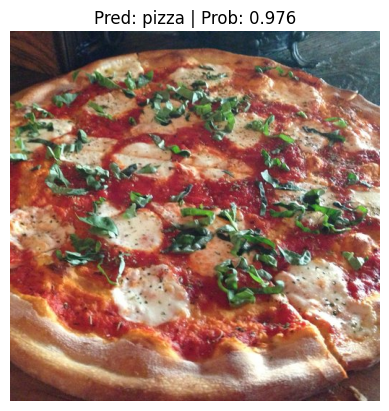

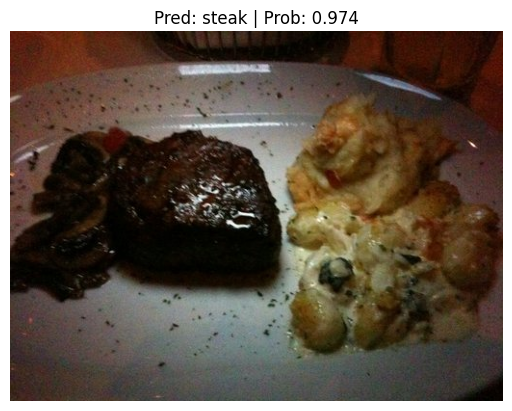

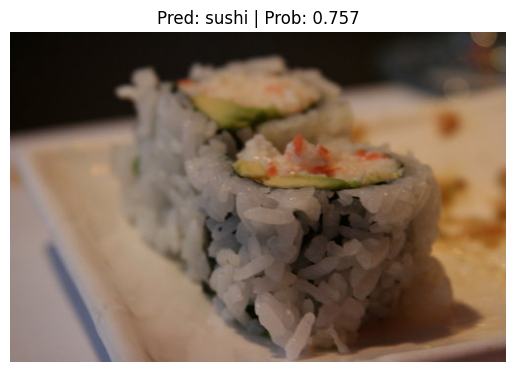

In [47]:
# Import function to make preds
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images
import random

test_paths_list = list(Path(data_20per_path/"test").glob("*/*.jpg"))
samples = random.sample(test_paths_list, k=3)

for img in samples:
    pred_and_plot_image(model=best_model,
                        image_path=str(img),
                        class_names=class_names,
                        device=torch.device(dev))

### 9.1 Predict on a custom image with the best model

I've taken this photo from a screenshot, so there will not be code to update it.

In [56]:
# Setup custom image path
custom_img_url = "https://imgs.search.brave.com/trca7LQeyk25XsDtv9dk_J6LcJuVvImV-iakdmyUV6s/rs:fit:200:200:1:0/g:ce/aHR0cHM6Ly9pLnl0/aW1nLmNvbS92aS9J/V0liNFRGUDkyUS9t/YXhyZXNkZWZhdWx0/LmpwZw"

# Downloading the image
from pathlib import Path
import requests as rq

data_path = Path("./")
if not data_path.exists():
    print(f"Creating data directory as: '{data_path}'...")
    data_path.mkdir()
else:
    print(f"Directory already exists, skipping this step.")
    
custom_image_path = data_path/"custom_image.jpg"
if not custom_image_path.exists():
    print(f"Downloading image at: '{custom_image_path}'...")
    request = rq.get(url=custom_img_url)
    with open(custom_image_path, "wb") as f:
        f.write(request.content)
else:
    print(f"Image already downladed, skipping this step.")

Directory already exists, skipping this step.


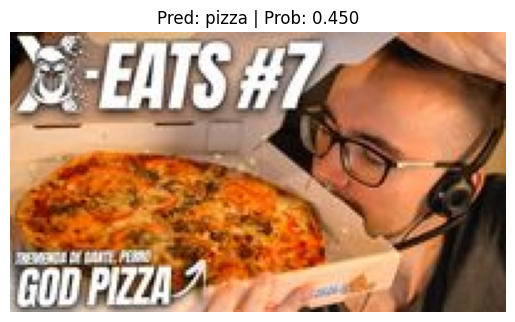

In [58]:
pred_and_plot_image(model=best_model,
                    class_names=class_names,
                    image_path="./custom_image.jpg")